In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logs = # TO FILL
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/bert/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

import sys
sys.path.append("../../../logging/mlperf_logging/")

from compliance_checker.mlp_parser import parse_file

# Preprocessing

In [2]:
jobs["sub_num-sample"] = jobs["sub_num-sample"].fillna(14000000)
jobs["cmd_train_batch_size"] = jobs["cmd_train_batch_size"].astype(int)
jobs["cmd_max_samples_termination"] = jobs["cmd_max_samples_termination"].astype(int)

# Computing the total number of images processed, which seems like the most relevant metric regarding energy consumption
jobs["total_batch_size"]=jobs["mllog_d_batch_size"]*jobs["node_nb"]*8
jobs["images_processed"] = jobs["block_nb"]*jobs["mllog_global_batch_size"]

In [3]:
jobs = jobs[(jobs["sub_num-sample"]==14000000)&(jobs["sub_seed"].notna())]

In [4]:
import os 
job_nodes = {}
all_nodes = []
for job in jobs["job_id"]:
    path = os.path.join("/Users/mathildepro/Documents/code_projects/hpe_logs/resultats-17-07-23/bert", str(job))
    nodes = [f for f in os.listdir(path) if "o186" in f]
    job_nodes[job] = {}
    for node in nodes:
        job_nodes[job][node] = True
job_nodes = pd.DataFrame(job_nodes).sort_index().T.fillna(False)

In [5]:
renaming_cols = {}
for col in job_nodes.columns:
    renaming_cols[col] = col[-2:]
job_nodes = job_nodes.rename(columns=renaming_cols)

In [6]:
job_nodes.style.applymap(lambda x: 'background-color : green' if x else '')

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_29027/1834120918.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  job_nodes.style.applymap(lambda x: 'background-color : green' if x else '')


,21,22,23,24,25,26,27,31
111768,False,False,True,True,False,False,True,True
111769,True,True,False,False,True,True,False,False
111770,False,False,True,True,False,False,True,True
111771,True,True,False,False,True,True,False,False
111772,False,False,True,True,False,False,True,True
111788,False,True,False,False,False,False,False,False
111789,False,False,False,False,False,True,False,False
111790,False,False,False,False,False,False,True,False
111791,False,False,False,True,False,False,False,False
111792,False,False,False,False,False,False,False,True


In [7]:
for job in jobs.job_id:
    x = job_nodes.loc[job]
    val = ",".join(x[x].index)
    jobs.loc[jobs["job_id"]==job, "nodes"] = val


In [8]:
jobs["nodes"]

45    23,24,27,31
46    21,22,25,26
47    23,24,27,31
48    21,22,25,26
49    23,24,27,31
65             22
66             26
67             27
68             24
69             31
70          22,23
71          25,26
72          24,27
73          21,31
74          22,23
Name: nodes, dtype: object

In [9]:
jobs["duration_total_ms"] = jobs["end_time_ms"] - jobs["start_time_ms"]
jobs["duration_srun_ms"] = jobs["end_time_ms"] - jobs["srun_start_time_ms"]
jobs["duration_training_ms"] = jobs["train_end_time_ms"] - jobs["srun_start_time_ms"]
jobs["duration_total_minutes"] = jobs["duration_total_ms"]/60000
jobs["duration_training_per_GPU_minutes"] = jobs["duration_training_ms"]/60000

# Conducted experiments

In [10]:
cols=['cmd_learning_rate', 'cmd_max_steps']
gp_by = ["node_nb", "nodes","sub_seed"] # "sub_seed" 
jobs[gp_by+["job_id"]].groupby(gp_by).count()["job_id"]

node_nb  nodes        sub_seed
1        22           51.0        1
         24           7.0         1
         26           6.0         1
         27           42.0        1
         31           9998.0      1
2        21,31        7.0         1
         22,23        51.0        1
                      9998.0      1
         24,27        42.0        1
         25,26        6.0         1
4        21,22,25,26  6.0         1
                      7.0         1
         23,24,27,31  42.0        1
                      51.0        1
                      9998.0      1
Name: job_id, dtype: int64

# Results

In [11]:
plot_df = jobs.sort_values(by=["duration_total_minutes", "node_nb"], ascending=False)

In [12]:
plot_df["node_nb_str"] = plot_df["node_nb"].astype(str)+" node(s)"

In [19]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

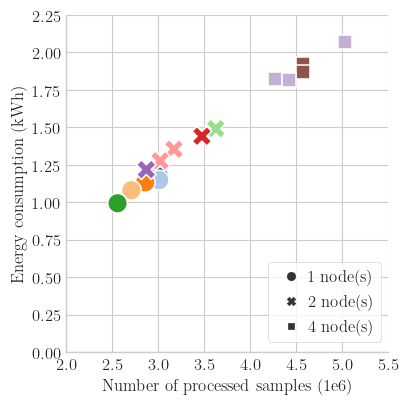

In [21]:
les_x = "images_processed"
les_y = "energy_kWh" # energy_kWh duration_total_minutes
labels = {
    "nodes":"Nodes", 
    "node_nb_str":"Number of\nnodes", 
    "energy_kWh":"Energy consumption (kWh)", 
    "images_processed":"Number of processed samples (1e6)",
    "duration_total_minutes":"Training time (minutes)"
    }
plt.figure(figsize=(15,8))
ax = sns.relplot(
    data=plot_df.rename(columns=labels),
    x=labels[les_x], y=labels[les_y], style=labels["node_nb_str"], hue=labels["nodes"], s=200, palette="tab20", height=4, aspect=1, facet_kws={'ylim': (0, plot_df[les_y].max())}
)
FONTSIZE = 12
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.set_xlabels(labels[les_x], fontsize=FONTSIZE)
ax.set_ylabels(labels[les_y], fontsize=FONTSIZE)
plt.legend(handles=ax._legend.legend_handles[-3:], loc='center left', alignment="right", bbox_to_anchor=(0.6, 0.15), handletextpad=0, frameon=True, fontsize=FONTSIZE)
ax._legend.remove()
# plt.tight_layout()
plt.savefig(f"/Users/mathildepro/Documents/code_projects/hpe_logs/graphs/BERT_{les_x}_vs_{les_y}.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"/Users/mathildepro/Documents/code_projects/hpe_logs/graphs/BERT_{les_x}_vs_{les_y}.png", bbox_inches='tight', dpi=300)

It can be noticed that when the number of nodes is multiplied by two, the duration is not divided by two by a factor of 1.5 and, as expected, training with twice as many nodes consumes more energy (by a factor of 1.31). This means that there is a tradeoff to find between minimizing the energy consumption and minimizing the training time. Five experiments were conducted, each one characterised by a seed and a set of nodes. The color indicate the set of nodes, as some of them otherlap particularly when the experiments require 4 nodes. It can be seen that the variability in time and energy is quite significant, due to the instability of training. It seems that the energy depends more on the number of samples that were needed to reach the accuracy than on the number of nodes. For the few data points for which the number of nodes is different and the number of processed samples is equivalent, it seems that more nodes consume more energy. It is likely due to the time overhead of transfering and aggregating data across nodes.

In [ ]:
data = jobs.groupby(["node_nb"])[["duration_total_minutes", "energy_kWh"]].agg(["mean", "std"])
data.style.format("{:.3f}")

In [ ]:
data.mean()

duration_total_minutes  mean    13.838889
                        std      0.937943
energy_kWh              mean     1.453343
                        std      0.096035
dtype: float64

In [ ]:
(data.shift()/data).mean(axis=0)

duration_total_minutes  mean    1.504622
                        std     1.698494
energy_kWh              mean    0.764400
                        std     0.853646
dtype: float64

In [ ]:
(data/data.shift()).mean(axis=0)

duration_total_minutes  mean    0.666494
                        std     0.625083
energy_kWh              mean    1.314025
                        std     1.259473
dtype: float64